<a href="https://colab.research.google.com/github/AMEERKOTTA/hands_on_machine_learning_with_sklearn_keras_and_tensorflow/blob/main/Intro%20to%20Tensorflow%20for%20Deep%20Learning/07-Time%20Series%20Forecasting/04_preparing_the_time_window.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PREPARING THE TIME WINDOW FROM SERIES**

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [21]:
dataset = tf.data.Dataset.range(10)
for val in dataset:
  print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [22]:
## defining the window size
## here 5 is the window size.
## shift = 1 implies the data will be shifted by 1 point.
dataset = dataset.window(5, shift=1, drop_remainder=True)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [25]:
## convert each window dataset into a tensor
## using the flat_map method
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [26]:
## to train a ml model we need training data and training labels
## so from the tensors, [0 1 2 3 4]
## first 4 points for training and last one is for label.
## it is done using the map method.
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x, y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [27]:
## use the shuffle method to shuffle the dataset
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
for x, y in dataset:
    print(x.numpy(), y.numpy())

[4 5 6 7] [8]
[0 1 2 3] [4]
[1 2 3 4] [5]
[5 6 7 8] [9]
[3 4 5 6] [7]
[2 3 4 5] [6]


In [31]:
## using the batch method to make batches to feed the ML models
## then prefetch is for while one batch is using the other batch is already in preperation to feed.
## here batch_size is given as 2
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x, y in dataset:
    print("x =", x.numpy())
    print("y =", y.numpy())

x = [[2 3 4 5]
 [1 2 3 4]]
y = [[6]
 [5]]
x = [[3 4 5 6]
 [0 1 2 3]]
y = [[7]
 [4]]
x = [[5 6 7 8]
 [4 5 6 7]]
y = [[9]
 [8]]


In [32]:
## function to do all these operation
def window_dataset(series, window_size, batch_size=32,shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [35]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

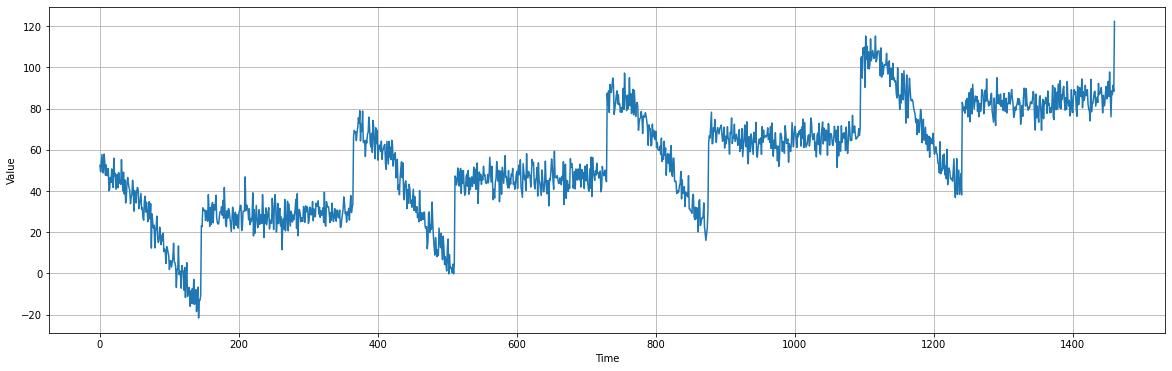

In [38]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(20, 6))
plot_series(time, series)
plt.show()

In [39]:
dataset = window_dataset(series, 100)

In [42]:
for x, y in dataset:
    print("x =", x.numpy())
    print("y =", y.numpy())

print(x.shape)
print(y.shape)

x = [[53.69100975 45.26643912 43.93559479 ... 45.72569158 44.56639491
  87.47922628]
 [49.8063698  55.5883969  51.99497968 ... 86.72619692 81.87249287
  82.43751401]
 [83.04582641 80.8733508  69.48581184 ... 22.85110627 19.33878121
  16.03705109]
 ...
 [23.80013652 22.70749832 30.45096482 ... 28.32025175 26.06134823
  28.5724506 ]
 [46.01809431 45.15264868 49.8063698  ... 88.63229718 82.29519348
  86.72619692]
 [22.97916016 30.23273938 30.21626751 ... 32.17886322 31.51688737
  28.38339287]]
y = [81.65220968 78.29620464 18.89146392 45.9575199  46.52087226 27.31777149
 19.33878121 40.5939975  77.6910381  63.00754996 43.04975671 36.14565759
 43.94202898 49.1115889  29.89204626 26.11219316 63.54779797 35.79332498
 47.68153279 31.52397911  4.53872226 56.44479609 20.79116199 65.2623122
 66.20382215 63.04496227 25.61907494 30.23339335 -7.1490677  31.33273546
 81.87249287 29.09762466]
x = [[22.62170452 26.09790179 28.65414135 ... 34.05023834 43.29642602
  41.15425085]
 [63.5598468  68.26948936

***